<a href="https://colab.research.google.com/github/AryanSkywalker/AS-P1-Gesture-Recognition/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modulation**

In [ ]:
from torch.utils.data import Dataset

import os
import sys

import cv2 as cv
import numpy as np
import torch
from torch import optim as optim
from torch import nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
from torchvision.utils import make_grid

import keyboard
import imutils

from matplotlib import pyplot as plt

import time
import shutil
import webbrowser

# **Neural Network and GestureSet Class Decalaration**

In [ ]:
class DustNet(nn.Module):

    def __init__(self, numGestures):

        super(DustNet, self).__init__()

        self.FeedForward = nn.Sequential(

            nn.Linear(784, 32),
            nn.Sigmoid(),
            #nn.Dropout(0.5),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            #nn.Dropout(0.5),
            nn.Linear(32, 16), 
            nn.Sigmoid(),
            nn.Linear(16, numGestures)
            
        )

    def forward(self, x):

        flatX = x.view(x.shape[0], -1)
        feedX = self.FeedForward(flatX)

        return feedX

    def Learn(self, data, epochs, lossFunc, optimizer, modelArchive, valData):

        lossArchive = []
        accuracyArchive = []
        loss = None
        minimumLoss = 10 ** 10

        for epoch in range(epochs):

            print('\n\n\nEpoch Iteration: ', epoch + 1)
            i = 0

            for images, labels in data:

                i += 1
                #print('Batch Iteration Index: ', i)

                outputs = self.forward(images)

                loss = lossFunc(outputs, labels)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            lossArchive.append(loss.item())
            accuracyArchive.append(self.Accurize(valData))

            if loss.item() <= minimumLoss:

              torch.save(self.state_dict(), os.path.join(modelArchive, 'bestModel.pth'))
              minimumLoss = loss.item()
              minLossEpoch = epoch

            modelName = 'model_' + str(epoch + 1) + '.pth'

            torch.save(self.state_dict(), os.path.join(modelArchive, modelName))

            print('Loss After Epoch ', epoch + 1, ': \t', loss.item(), 'Validation Accuracy: ', self.Accurize(valData))

            if  keyboard.is_pressed('a'):

              print('Manual Abort...')
              break


        plt.plot(lossArchive)
        print('Final Loss: ', loss.item(), 'Final Loss Validation Accuracy: ', accuracyArchive[-1])
        print('\nMinimum Loss: ', minimumLoss, 'Minimum Loss Validation Accuracy: ', accuracyArchive[minLossEpoch])

        bestEpoch = accuracyArchive.index(max(accuracyArchive))
      
        print('\nBest Loss: ', lossArchive[bestEpoch], 'Best Loss Validation Accuracy: ', max(accuracyArchive))

        bestModelName = os.path.join(modelArchive, 'model_' + str(bestEpoch + 1) + '.pth')
        self.load_state_dict(torch.load(bestModelName))

        plt.savefig('Models/Loss Visualization.png')
        plt.show()

    def Accurize(self, valLoader):

        total, correct = 0, 0

        for images, labels in valLoader:

            predictions = self.forward(images)

            t, binarizedPredictions = torch.max(predictions, 1)

            total += images.shape[0]
            correct += (labels == binarizedPredictions).sum().item()

        return correct / total * 100

    def Predict(self, X):

        yH = self.forward(X)
        t, predictions = torch.max(yH, 1)

        return predictions

In [ ]:
class GestureDataset(Dataset):

    def __init__(self, images, labels, transform):

        self.images = images
        self.labels = labels
        self.transform = transform

        self.dataset = list(zip(images, labels))

    def __len__(self):

        return len(self.dataset)

    def __getitem__(self, index):

        tarImages, tarLabels = self.dataset[index]
        tarImages = self.transform(tarImages.permute(2, 0, 1))
        item = (tarImages, tarLabels)

        return item

# **Data Collection**

In [ ]:
webCam = cv.VideoCapture(0)
x, y, w, h = 200, 100, 224, 224
scanCandidates = ['Stop', 'Surrender']
intervalTime = 5
dataNum, numScans = 1000, len(scanCandidates)
root = './Gestures/'
gestureDecoder = {}
decodedGestures = {}
gestureKey = 0

for directory in os.listdir(root):
    shutil.rmtree(os.path.join(root, directory))


def ReadGesture(gesture):

    index = 0

    while True:

        ret, frame = webCam.read()

        analysis = cv.rectangle(frame.copy(), (x, y), (x + w, y + h), (80, 199, 199), 2)
        cv.imshow('Analysis', analysis)

        if keyboard.is_pressed('a'):

            index += 1
            print(index)

            if index > dataNum:
                break

            extraction = frame[y:y + h, x:x + w]
            cv.imshow('Extraction', extraction)
            print(extraction.shape)

            filePath = root + gesture + '/' + str(index) + '.png'

            if gesture in gestureDecoder.values():

                resizedExtraction = imutils.resize(extraction, w, h)

                cv.imwrite(filePath, resizedExtraction)

            else:

                global gestureKey

                os.mkdir(root + gesture)
                gestureDecoder[gestureKey] = gesture
                decodedGestures[gesture] = gestureKey

                gestureKey += 1

                resizedExtraction = imutils.resize(extraction, w, h)

                cv.imwrite(filePath, resizedExtraction)

        if cv.waitKey(1) == 13:
            break

    print('Gesture Scanned: ' + gesture)


for candidate in scanCandidates:
    ReadGesture(candidate)
    time.sleep(intervalTime)

cv.destroyAllWindows()

print('Mission Report: ', gestureDecoder, gestureKey)

eigenVectors = {'scanCandidates': scanCandidates, 'intervalTime': intervalTime, 'decodedGestures': decodedGestures,
                'gestureDecoder': gestureDecoder, 'dataNum': dataNum, 'gestureKey': gestureKey, 'numScans': numScans}

with open('Eigen Vectors.txt', 'w') as eigen:
    print(eigenVectors, file=eigen, end='')

print('Compleska')

1
(224, 224, 3)
2
(224, 224, 3)
3
(224, 224, 3)
4
(224, 224, 3)
5
(224, 224, 3)
6
(224, 224, 3)
7
(224, 224, 3)
8
(224, 224, 3)
9
(224, 224, 3)
10
(224, 224, 3)
11
(224, 224, 3)
12
(224, 224, 3)
13
(224, 224, 3)
14
(224, 224, 3)
15
(224, 224, 3)
16
(224, 224, 3)
17
(224, 224, 3)
18
(224, 224, 3)
19
(224, 224, 3)
20
(224, 224, 3)
21
(224, 224, 3)
22
(224, 224, 3)
23
(224, 224, 3)
24
(224, 224, 3)
25
(224, 224, 3)
26
(224, 224, 3)
27
(224, 224, 3)
28
(224, 224, 3)
29
(224, 224, 3)
30
(224, 224, 3)
31
(224, 224, 3)
32
(224, 224, 3)
33
(224, 224, 3)
34
(224, 224, 3)
35
(224, 224, 3)
36
(224, 224, 3)
37
(224, 224, 3)
38
(224, 224, 3)
39
(224, 224, 3)
40
(224, 224, 3)
41
(224, 224, 3)
42
(224, 224, 3)
43
(224, 224, 3)
44
(224, 224, 3)
45
(224, 224, 3)
46
(224, 224, 3)
47
(224, 224, 3)
48
(224, 224, 3)
49
(224, 224, 3)
50
(224, 224, 3)
51
(224, 224, 3)
52
(224, 224, 3)
53
(224, 224, 3)
54
(224, 224, 3)
55
(224, 224, 3)
56
(224, 224, 3)
57
(224, 224, 3)
58
(224, 224, 3)
59
(224, 224, 3)
60
(22

# **Data Processing**

In [ ]:
with open('Eigen Vectors.txt', 'r') as eigen:

    eigenVectors = eval(eigen.read())

print(eigenVectors)



images = []
labels = []
batchSize = 100


def ReadImagesFromFolder(folderPath, gesture, realaFolder):
    imagesList = os.listdir(folderPath)

    for imageName in imagesList:
        imagePath = os.path.join(folderPath, imageName)

        image = cv.imread(imagePath)

        realaFolder.append(image)
        labels.append(eigenVectors['decodedGestures'][gesture])

        print('Current Data Length: ', len(realaFolder), '\t\tClass: ', eigenVectors['decodedGestures'][gesture])

    print('Gesture: ', gesture, '\t\tStatus: Loading Successful')
    return


ultimatePath = './Gestures'

directories = os.listdir(ultimatePath)

for directory in directories:

    gestureDirectory = os.path.join(ultimatePath, directory)

    ReadImagesFromFolder(gestureDirectory, directory, images)

    print('Current Status -- \t Data Length: ', len(images), 'Labels Length: ', len(labels), '\n\n\n')


xTrain, xTest, yTrain, yTest = train_test_split(images, labels, stratify=labels, random_state=1, test_size=0.20)
xTest, xVal,  yTest, yVal = train_test_split(xTest, yTest, stratify=yTest, random_state=1, test_size=0.50)

xTrain, yTrain, xTest, yTest, xVal, yVal = map(torch.tensor, [xTrain, yTrain, xTest, yTest, xVal, yVal])

print('Torch Train--- \t X Shape: ', xTrain.shape, 'Y Shape: ', yTrain.shape)
print('Torch Test--- \t X Shape: ', xTest.shape, 'Y Shape: ', yTest.shape)
print('Torch Validation--- \t X Shape: ', xVal.shape, 'Y Shape: ', yVal.shape)

{'scanCandidates': ['Stop', 'Surrender'], 'intervalTime': 5, 'decodedGestures': {'Stop': 0, 'Surrender': 1}, 'gestureDecoder': {0: 'Stop', 1: 'Surrender'}, 'dataNum': 1000, 'gestureKey': 2, 'numScans': 2}
Current Data Length:  1 		Class:  0
Current Data Length:  2 		Class:  0
Current Data Length:  3 		Class:  0
Current Data Length:  4 		Class:  0
Current Data Length:  5 		Class:  0
Current Data Length:  6 		Class:  0
Current Data Length:  7 		Class:  0
Current Data Length:  8 		Class:  0
Current Data Length:  9 		Class:  0
Current Data Length:  10 		Class:  0
Current Data Length:  11 		Class:  0
Current Data Length:  12 		Class:  0
Current Data Length:  13 		Class:  0
Current Data Length:  14 		Class:  0
Current Data Length:  15 		Class:  0
Current Data Length:  16 		Class:  0
Current Data Length:  17 		Class:  0
Current Data Length:  18 		Class:  0
Current Data Length:  19 		Class:  0
Current Data Length:  20 		Class:  0
Current Data Length:  21 		Class:  0
Current Data Length:  22 		

In [ ]:
labels.count(0)

1000

In [ ]:
b = transforms.Compose([

    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize(28),
    transforms.ToTensor()

])

sep = GestureDataset(xTrain, yTrain, b)
l = DataLoader(sep, shuffle=False, batch_size=1600)

for images, __  in l:

  images = images.view(images.size(0), images.size(1), -1)

  mean = images.mean(2).sum(0)
  std = images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print(mean, std)


tensor([0.5476]) tensor([0.1710])


In [ ]:
batchSize = 1600

transmogrificationTransformer = transforms.Compose([

    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5476), (0.1710))

])


dataset = GestureDataset(xTrain, yTrain, transmogrificationTransformer)
loader = DataLoader(dataset, shuffle=True, batch_size=batchSize)

print('DataSet Length -- \t', len(dataset))

DataSet Length -- 	 1600


In [ ]:
testDataset = GestureDataset(xTest, yTest, transmogrificationTransformer)
testLoader = DataLoader(testDataset, shuffle=False, batch_size=200)

In [ ]:
valDataset = GestureDataset(xVal, yVal, transmogrificationTransformer)
valLoader = DataLoader(valDataset, shuffle=True, batch_size=200)

# **Visualization**

In [ ]:
batchSize = 512

def DisplayImage(image, title):
    image = np.transpose(image, [1, 2, 0])

    cv.imshow(title, image)

    while True:

        if cv.waitKey(0) == 13:
            break


def DisplayBatch(loader):
    images, labels = next(iter(loader))

    batchGrid = make_grid(images)

    print('Grid Shape: ', batchGrid.shape)

    DisplayImage(batchGrid.numpy(), ' '.join([str(x) for x in labels.tolist()]))
    print('Batch Visualization Successful!!')

DisplayBatch(loader)

Grid Shape:  torch.Size([3, 302, 242])
Batch Visualization Successful!!


# **Window Kill Statement**

In [ ]:
cv.destroyAllWindows()
webCam.release()

# **Learning**

In [ ]:
Dusty = DustNet(eigenVectors['numScans'])
learningRate, epochs, momentum = 0.75, 100, 0.75
ModelArchive = 'Models'


Optimizer = optim.SGD(Dusty.parameters(), lr=learningRate, momentum=0.75)
CrossEntropize = nn.CrossEntropyLoss()


In [ ]:
learningRate, epochs = 0.5, 2500
Optimizer = optim.SGD(Dusty.parameters(), lr=learningRate, momentum=0.9)




Epoch Iteration:  1
Loss After Epoch  1 : 	 0.6928136348724365 Validation Accuracy:  68.5



Epoch Iteration:  2
Loss After Epoch  2 : 	 0.6928112506866455 Validation Accuracy:  64.5



Epoch Iteration:  3
Loss After Epoch  3 : 	 0.692807674407959 Validation Accuracy:  68.5



Epoch Iteration:  4
Loss After Epoch  4 : 	 0.6928017139434814 Validation Accuracy:  70.5



Epoch Iteration:  5
Loss After Epoch  5 : 	 0.6927940249443054 Validation Accuracy:  71.0



Epoch Iteration:  6
Loss After Epoch  6 : 	 0.6927852630615234 Validation Accuracy:  67.0



Epoch Iteration:  7
Loss After Epoch  7 : 	 0.692775547504425 Validation Accuracy:  66.5



Epoch Iteration:  8
Loss After Epoch  8 : 	 0.6927635073661804 Validation Accuracy:  67.0



Epoch Iteration:  9
Loss After Epoch  9 : 	 0.6927509307861328 Validation Accuracy:  71.0



Epoch Iteration:  10
Loss After Epoch  10 : 	 0.6927364468574524 Validation Accuracy:  71.5



Epoch Iteration:  11
Loss After Epoch  11 : 	 0.6927204132080078 Va

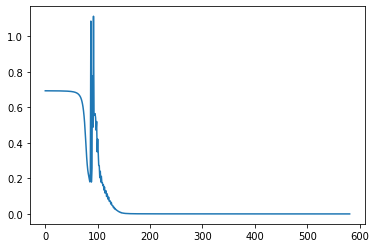

Learning Completed!!!


In [ ]:
Dusty.Learn(loader, epochs, CrossEntropize, Optimizer, modelArchive=ModelArchive, valData=valLoader)
print('Learning Completed!!!')

In [ ]:
torch.save(Dusty.state_dict(), 'Models/a965.pth')

In [ ]:
Dusty.load_state_dict(torch.load('Models/model_84.pth'))

<All keys matched successfully>

In [ ]:
batchSize = 50

DisplayBatch(testLoader)

# **Testing**

In [ ]:
#Dusty.load_state_dict(torch.load(bestModelArchive))

testAccuracy = Dusty.Accurize(testLoader)
print('Test Accuracy: \t', testAccuracy)

Test Accuracy: 	 96.5


In [ ]:
x, y, w, h = 200, 100, 224, 224

webCam = cv.VideoCapture(0)

while True:

    print('\nRunning...')

    ret, frame = webCam.read()

    analysis = cv.rectangle(frame.copy(), (x, y), (x + w, y + h), (80, 199, 199), 2)

    cv.imshow('Analysis', analysis)

    if keyboard.is_pressed('a'):

        extraction = frame[y:y + h, x:x + w]
        resizedExtraction = torch.tensor(imutils.resize(extraction, w, h))
        transExtraction = transmogrificationTransformer(resizedExtraction.permute((2, 1, 0)))

        #print('Extraction Shape: ', transExtraction.shape, 'Extraction Type: ', type(transExtraction))

        predictions = Dusty.Predict(transExtraction.view(1, -1))

        print('Gesture: ', eigenVectors['gestureDecoder'][predictions.item()], 'Predictins: ', predictions.item())

        gesture = eigenVectors['gestureDecoder'][predictions.item()]

        MusicPlugin(gesture)

    if cv.waitKey(1) == 13:

        break


Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Running...

Run

In [ ]:
DisplayBatch(testLoader)

Grid Shape:  torch.Size([3, 32, 152])
Batch Visualization Successful!!


# **Miscellaneous**

In [ ]:
chromePath = "C:/Program Files (x86)/Google/Chrome/Application/chrome.exe"
webbrowser.register('chrome', None, webbrowser.BackgroundBrowser(chromePath))
webbrowser.get('chrome')

In [ ]:
torch.save(Dusty.state_dict(), 'Best Model/sierraModel.pth')

# **Plugins**

In [ ]:
def MusicPlugin(gesture):

  if gesture == 'Stop':

    try:

      client = webbrowser.get("chrome")
      client.open("https://www.youtube.com/watch?v=iYKXdt0LRs8&ab_channel=TravisScottVEVO")

    except webbrowser.Error as e:

      print('Error Encountered: ', e)

    time.sleep(10)

  elif gesture == 'Surrender':

    try:

      client = webbrowser.get('chrome')
      client.open("https://www.youtube.com/watch?v=pgN-vvVVxMA&ab_channel=XXXTENTACION")

    except webbrowser.Error as e:

      print('Error Encountered: ', e)

    time.sleep(10)

# **Convolution Mode On**

In [ ]:
class DustNet(nn.Module):

    def __init__(self, numGestures):

        super(DustNet, self).__init__()

        self.FeedForward = nn.Sequential(

            nn.Linear(784, 32),
            nn.Sigmoid(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.Linear(32, 16), 
            nn.Sigmoid(),
            nn.Linear(16, numGestures)
            
        )

    def forward(self, x):

        flatX = x.view(x.shape[0], -1)
        feedX = self.FeedForward(flatX)

        return feedX

    def Learn(self, data, epochs, lossFunc, optimizer, modelArchive, valData):

        lossArchive = []
        accuracyArchive = []
        loss = None
        minimumLoss = 10 ** 10

        for epoch in range(epochs):

            print('\n\n\nEpoch Iteration: ', epoch + 1)
            i = 0

            for images, labels in data:

                i += 1
                #print('Batch Iteration Index: ', i)

                outputs = self.forward(images)

                loss = lossFunc(outputs, labels)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()

            lossArchive.append(loss.item())
            accuracyArchive.append(self.Accurize(valData))

            if loss.item() <= minimumLoss:

              torch.save(self.state_dict(), os.path.join(modelArchive, 'bestModel.pth'))
              minimumLoss = loss.item()
              minLossEpoch = epoch

            modelName = 'model_' + str(epoch + 1) + '.pth'

            torch.save(self.state_dict(), os.path.join(modelArchive, modelName))

            print('Loss After Epoch ', epoch + 1, ': \t', loss.item(), 'Validation Accuracy: ', self.Accurize(valData))

            if  keyboard.is_pressed('a'):

              print('Manual Abort...')
              break


        plt.plot(lossArchive)
        print('Final Loss: ', loss.item(), 'Final Loss Validation Accuracy: ', accuracyArchive[-1])
        print('\nMinimum Loss: ', minimumLoss, 'Minimum Loss Validation Accuracy: ', accuracyArchive[minLossEpoch])

        bestEpoch = accuracyArchive.index(max(accuracyArchive))
      
        print('\nBest Loss: ', lossArchive[bestEpoch], 'Best Loss Validation Accuracy: ', max(accuracyArchive))

        bestModelName = os.path.join(modelArchive, 'model_' + str(bestEpoch + 1) + '.pth')
        self.load_state_dict(torch.load(bestModelName))

        plt.savefig('Models/Loss Visualization.png')
        plt.show()

    def Accurize(self, valLoader):

        total, correct = 0, 0

        for images, labels in valLoader:

            predictions = self.forward(images)

            t, binarizedPredictions = torch.max(predictions, 1)

            total += images.shape[0]
            correct += (labels == binarizedPredictions).sum().item()

        return correct / total * 100

    def Predict(self, X):

        yH = self.forward(X)
        t, predictions = torch.max(yH, 1)

        return predictions

NameError: ignored

In [ ]:
class GestureDataset(Dataset):

    def __init__(self, images, labels, transform):

        self.images = images
        self.labels = labels
        self.transform = transform

        self.dataset = list(zip(images, labels))

    def __len__(self):

        return len(self.dataset)

    def __getitem__(self, index):

        tarImages, tarLabels = self.dataset[index]
        tarImages = self.transform(tarImages.permute(2, 0, 1))
        item = (tarImages, tarLabels)

        return item

In [ ]:
with open('Eigen Vectors.txt', 'r') as eigen:

    eigenVectors = eval(eigen.read())

print(eigenVectors)



images = []
labels = []
batchSize = 100


def ReadImagesFromFolder(folderPath, gesture, realaFolder):
    imagesList = os.listdir(folderPath)

    for imageName in imagesList:
        imagePath = os.path.join(folderPath, imageName)

        image = cv.imread(imagePath)

        realaFolder.append(image)
        labels.append(eigenVectors['decodedGestures'][gesture])

        print('Current Data Length: ', len(realaFolder), '\t\tClass: ', eigenVectors['decodedGestures'][gesture])

    print('Gesture: ', gesture, '\t\tStatus: Loading Successful')
    return


ultimatePath = './Gestures'

directories = os.listdir(ultimatePath)

for directory in directories:

    gestureDirectory = os.path.join(ultimatePath, directory)

    ReadImagesFromFolder(gestureDirectory, directory, images)

    print('Current Status -- \t Data Length: ', len(images), 'Labels Length: ', len(labels), '\n\n\n')


xTrain, xTest, yTrain, yTest = train_test_split(images, labels, stratify=labels, random_state=1, test_size=0.20)
xTest, xVal,  yTest, yVal = train_test_split(xTest, yTest, stratify=yTest, random_state=1, test_size=0.50)

xTrain, yTrain, xTest, yTest, xVal, yVal = map(torch.tensor, [xTrain, yTrain, xTest, yTest, xVal, yVal])

print('Torch Train--- \t X Shape: ', xTrain.shape, 'Y Shape: ', yTrain.shape)
print('Torch Test--- \t X Shape: ', xTest.shape, 'Y Shape: ', yTest.shape)
print('Torch Validation--- \t X Shape: ', xVal.shape, 'Y Shape: ', yVal.shape)